/tmp/ipykernel_201962/1851886630.py:156: UserWarning: frames=<generator object animate at 0x7f3f025b0700> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  anim = FuncAnimation(fig, lambda artists: artists, frames=animate())
/home/ambien/miniconda3/envs/main/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Processed: /mnt/c/users/micha/downloads/output/20080208/cfrad.20080208_074541.625_to_20080208_074552.000_Redbank__RHI.nc
Animation saved as rhi_animation.mp4


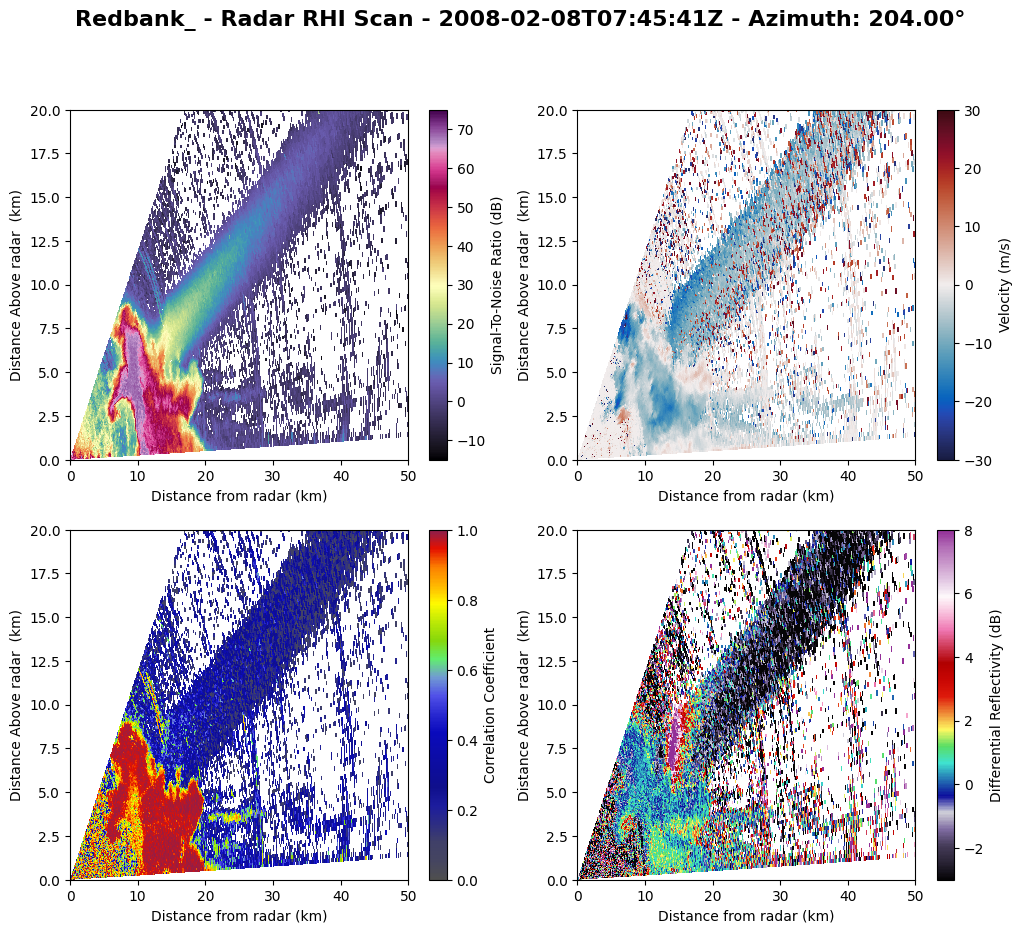

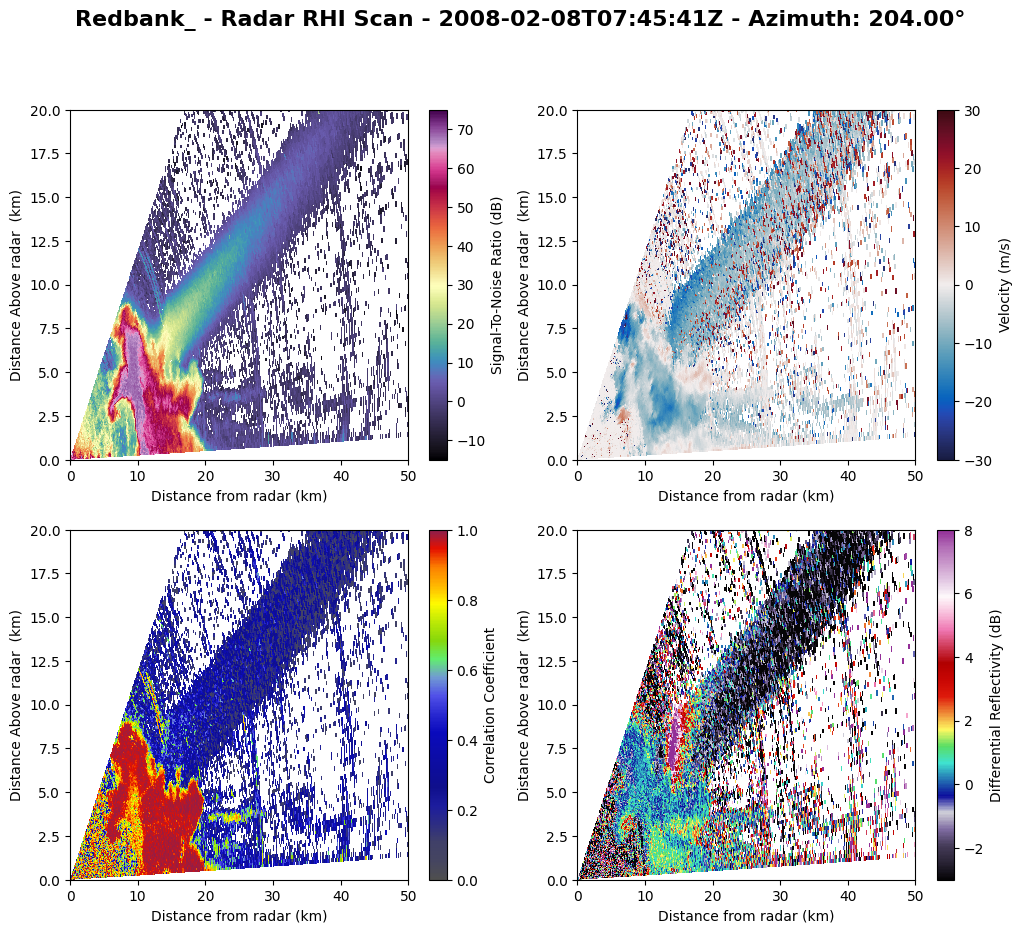

In [5]:
import os
import pyart
import matplotlib.colors as colors
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
 ## @multidoppler on xitter ## 
 ## this dataset was retrieved from the BOM TDS catalog: https://thredds.nci.org.au/thredds/catalog/hj10/cp2/level_1/s_band/rhi/2008/catalog.html ##
 ## Processed with LROSE https://github.com/NCAR/lrose-core ## 

hex_colors = ['#922E97', '#B26CB6', '#C998CB', '#E2C7E3', '#FEF9FB', '#F8BEDB', '#EF77B2', '#CF3B58', '#B00000', '#C80603', '#DE1A0B', '#EE8836', '#FEF861', '#5ADE64', '#3FE2CF', '#2474B4', '#0B0D9C', '#D1D1D9', '#7F6CA2', '#453B58', '#292335', '#060507']
rgb_colors = [mcolors.hex2color(hex_code) for hex_code in hex_colors] # not so hastily made AWIPS ZDR 

reversed_rgb_colors = rgb_colors[::-1] # Maybe someday ill make a dedicated software to this 

custom_colormap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", reversed_rgb_colors)





hex_colors = ['#8B1E4D', '#E41000', '#FC7F00', '#FFB600', '#FFFB00', '#BCE906', '#87D70B', '#61ED6E', '#719CD2', '#5151E8', '#2929D1', '#0A0ABD', '#0C0CAC', '#0D0D9C', '#0F0F8C', '#1C1C9E', '#2D2D84', '#404068', '#454561', '#4F4F4F']
rgb_colors = [mcolors.hex2color(hex_code) for hex_code in hex_colors] # hastily prepared AWIPS CC

reversed_rgb_colors = rgb_colors[::-1] # reverse the colors if you decided to extract the hex codes from top to bottom

cc_colormap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", reversed_rgb_colors)

input_folder = "/mnt/c/users/micha/downloads/output/20080208"
output_animation = "rhi_animation.mp4"

# X axis minimum (KM)
x_min_distance = 0   

# X axis height (KM)
x_max_distance = 50   

# y axis height (KM)
y_max_height = 20   



# Toggle panel layouts
single_panel = False  # False for 4 panel mode


def load_radar_files(folder):
    files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".nc")]
    files.sort()
    return files


def extract_datetime(radar):
    start_time = radar.time['units']  # '2023-01-01T00:00:00Z'
    datetime_str = start_time.split('since')[-1].strip()
    return datetime_str


def extract_radar_name(radar):
    return radar.metadata.get('instrument_name', 'Unknown Radar')


# Extract the azimuth of the file 
def extract_azimuth(radar, sweep_index):
    azimuths = radar.azimuth['data']
    return azimuths[sweep_index]


# Plot your single panel layout
def plot_rhi_single(radar, ax, title):
    display = pyart.graph.RadarDisplay(radar)
    ax.clear()
    display.plot_rhi(
        field="SNR",
        sweep=0,
        ax=ax,
        colorbar_label="Reflectivity (dBZ)", cmap='ChaseSpectral', vmin=-10, vmax=70, filter_transitions=False
    )
    ax.set_xlim(x_min_distance, x_max_distance)  # Set the x-axis limits
    ax.set_title(title, fontweight="bold")
    ax.set_ylim(0, y_max_height)  # Set the y-axis limits


# plot a 4-panel RHI layout
def plot_rhi_4panel(radar, axs, title):
    display = pyart.graph.RadarDisplay(radar)

    fields = [
        ("SNR", "Signal-To-Noise Ratio (dB)", -15, 75, 'ChaseSpectral'),
        ("VEL", "Velocity (m/s)", -30, 30, 'pyart_balance'),
        ("RHOHV", "Correlation Coefficient", 0, 1.0, cc_colormap),
        ("ZDR", "Differential Reflectivity (dB)", -3, 8, custom_colormap)]

    for ax, (field, label, vmin, vmax, cmap) in zip(axs.flatten(), fields):
        ax.clear()
        display.plot_rhi(
            field=field,
            sweep=0,
            ax=ax,
            colorbar_label=label,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            title=''  # Ensure no title on individual panels
        )
        ax.set_xlim(x_min_distance, x_max_distance)  # Set the x-axis limits
        ax.set_ylim(0, y_max_height)  # Set the y-axis limits




# Load your data
radar_files = load_radar_files(input_folder)
if not radar_files:
    print("No radar files found in the specified folder.")
    exit()


if single_panel:
    fig, ax = plt.subplots(figsize=(10, 6))   
else:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  




def animate():
    for frame in range(len(radar_files)):
        fig.clf()  # Clear the figure for both modes

        if single_panel:
            ax = fig.add_subplot(111)
        else:
            axs = fig.subplots(2, 2)

        radar = pyart.io.read(radar_files[frame])
        datetime_str = extract_datetime(radar)
        radar_name = extract_radar_name(radar)
        azimuth = extract_azimuth(radar, 0)  # Assume first sweep (index 0)
        title = f"{radar_name} - Radar RHI Scan - {datetime_str} - Azimuth: {azimuth:.2f}°"

        if single_panel:
            plot_rhi_single(radar, ax, title)
        else:
            plot_rhi_4panel(radar, axs, title)
            fig.suptitle(title, fontsize=16, fontweight="bold")  # super title

        print(f"Processed: {radar_files[frame]}")  # Print the file it just finished
        yield fig.artists





# Create the animation
anim = FuncAnimation(fig, lambda artists: artists, frames=animate())
# Save it
anim.save(output_animation, writer="ffmpeg", fps=10, dpi=144)
print(f"Animation saved as {output_animation}")

radar = pyart.io.read(radar_files[0])
datetime_str = extract_datetime(radar)
radar_name = extract_radar_name(radar)
azimuth = extract_azimuth(radar, 0)  # Assume first sweep (index 0)
title = f"{radar_name} - Radar RHI Scan - {datetime_str} - Azimuth: {azimuth:.2f}°"

if single_panel:
    fig, ax = plt.subplots(figsize=(10, 6))  # Create a single-panel figure
    plot_rhi_single(radar, ax, title)
else:
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # Create a 4-panel figure
    plot_rhi_4panel(radar, axs, title)
    fig.suptitle(title, fontsize=16, fontweight="bold")  # Bold super title for the first frame

 